In this exercise, we will extend Ex1 by predicting the bounding box. The model will be two head: one will be for classification and the other for regression

# Import libs

In [20]:
import os
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.models.resnet import ResNet18_Weights
from PIL import Image

# Data

## Download

In [5]:
import kagglehub

current_dir = os.getcwd()
os.environ['KAGGLEHUB_CACHE'] = current_dir
data_dir = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")
print(f"Data directory: {data_dir}")

Data directory: c:\Learning\AIO\AIO24\Module7\ObjectDetection_Part1\datasets\andrewmvd\dog-and-cat-detection\versions\1


## Pytorch dataset

In [3]:
# Dataset Class
class ImageDataset(Dataset):
    def __init__(self, annotations_dir, image_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects()

    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                img_name = f
                annotation_name = os.path.splitext(img_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                if self.count_objects_in_annotation(annotation_path) == 1:
                    valid_image_files.append(img_name)
        return valid_image_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for obj in root.findall('object'):
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Image path
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Annotation path
        annotation_name = os.path.splitext(img_name)[0] + ".xml"
        annotation_path = os.path.join(self.annotations_dir, annotation_name)

        # Parse annotation
        label, bbox = self.parse_annotation(annotation_path)  # Get both label and bbox

        if self.transform:
            image = self.transform(image)

        return image, label, bbox

    def parse_annotation(self, annotation_path):
      tree = ET.parse(annotation_path)
      root = tree.getroot()

      # Get image size for normalization
      image_width = int(root.find('size/width').text)
      image_height = int(root.find('size/height').text)

      label = None
      bbox = None
      for obj in root.findall('object'):
          name = obj.find('name').text
          if label is None:  # Take the first label
              label = name
              # Get bounding box coordinates
              xmin = int(obj.find('bndbox/xmin').text)
              ymin = int(obj.find('bndbox/ymin').text)
              xmax = int(obj.find('bndbox/xmax').text)
              ymax = int(obj.find('bndbox/ymax').text)

              # Normalize bbox coordinates to [0, 1]
              bbox = [
                  xmin / image_width,
                  ymin / image_height,
                  xmax / image_width,
                  ymax / image_height,
              ]

      # Convert label to numerical representation (0 for cat, 1 for dog)
      label_num = 0 if label == 'cat' else 1 if label == 'dog' else -1

      return label_num, torch.tensor(bbox, dtype=torch.float32)

In [6]:
annotation_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageDataset(annotations_dir=annotation_dir, image_dir=image_dir, transform=data_transforms)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [10]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Modeling

In [7]:
# Model with Two Heads
class TwoHeadedModel(nn.Module):
    def __init__(self, num_classes=2):
        super(TwoHeadedModel, self).__init__()
        self.base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.num_ftrs = self.base_model.fc.in_features

        # Remove the original fully connected layer
        self.base_model.fc = nn.Identity()

        # Classification head
        self.classifier = nn.Linear(self.num_ftrs, num_classes)

        # Bounding box regression head
        self.regressor = nn.Linear(self.num_ftrs, 4)

    def forward(self, x):
        x = self.base_model(x)
        class_logits = self.classifier(x)
        bbox_coords = torch.sigmoid(self.regressor(x))
        return class_logits, bbox_coords

In [11]:
# Model
model = TwoHeadedModel()

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

In [17]:
# Training Loop
for epoch in range(num_epochs):
    model.train()
    for data, targets, bboxes in train_loader:
        data = data.to(device)
        targets = targets.to(device)
        bboxes = bboxes.to(device)

        scores, pred_bboxes = model(data)
        loss_class = criterion_class(scores, targets)
        loss_bbox = criterion_bbox(pred_bboxes, bboxes)
        loss = loss_class + loss_bbox  # Combine losses

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        total_loss_bbox = 0
        total_samples = 0
        for data, targets, bboxes in val_loader:
            data = data.to(device)
            targets = targets.to(device)
            bboxes = bboxes.to(device)

            scores, pred_bboxes = model(data)
            _, predictions = scores.max(1)
            correct += (predictions == targets).sum()
            total += targets.size(0)

            # Calculate bbox loss for monitoring (optional)
            total_loss_bbox += criterion_bbox(pred_bboxes, bboxes).item() * data.size(0)
            total_samples += data.size(0)

        avg_loss_bbox = total_loss_bbox / total_samples

        print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {float(correct)/float(total)*100:.2f}%, '
              f'Avg. Bbox Loss: {avg_loss_bbox:.4f}')

Epoch 1/10, Validation Accuracy: 94.57%, Avg. Bbox Loss: 0.0170
Epoch 2/10, Validation Accuracy: 93.62%, Avg. Bbox Loss: 0.0133
Epoch 3/10, Validation Accuracy: 94.57%, Avg. Bbox Loss: 0.0119
Epoch 4/10, Validation Accuracy: 91.04%, Avg. Bbox Loss: 0.0086
Epoch 5/10, Validation Accuracy: 91.18%, Avg. Bbox Loss: 0.0096
Epoch 6/10, Validation Accuracy: 94.17%, Avg. Bbox Loss: 0.0107
Epoch 7/10, Validation Accuracy: 92.13%, Avg. Bbox Loss: 0.0098
Epoch 8/10, Validation Accuracy: 95.66%, Avg. Bbox Loss: 0.0084
Epoch 9/10, Validation Accuracy: 88.60%, Avg. Bbox Loss: 0.0119
Epoch 10/10, Validation Accuracy: 93.08%, Avg. Bbox Loss: 0.0091


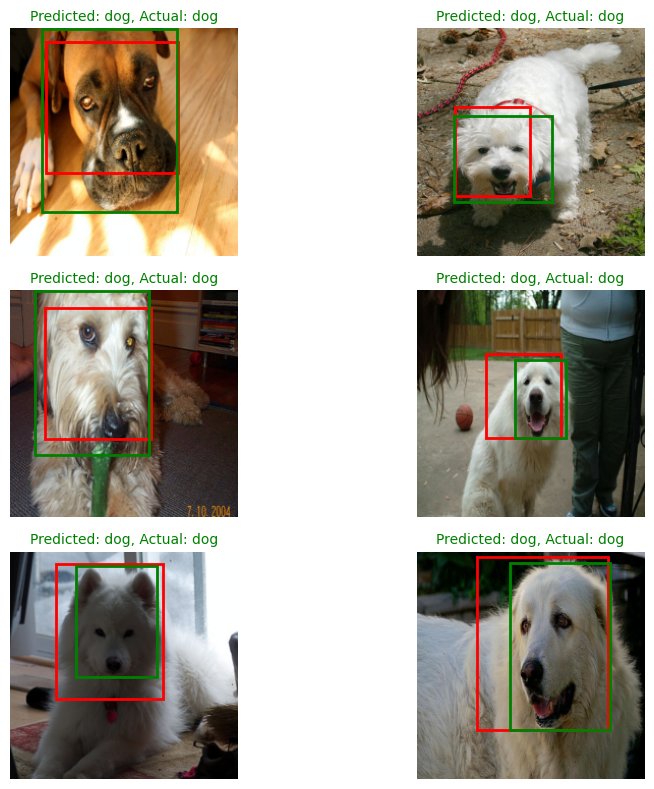

In [21]:
# Function to visualize predictions with bounding boxes
def visualize_predictions_with_bbox(model, dataloader, num_images=6):
    model.eval()
    images_so_far = 0
    class_names = ["cat", "dog"]
    fig = plt.figure(figsize=(10, 8))

    with torch.no_grad():
        for i, (images, labels, bboxes) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            class_outputs, bbox_outputs = model(images)
            _, preds = torch.max(class_outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')

                # Denormalize and display the image
                img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = [0.485, 0.456, 0.406]
                std = [0.229, 0.224, 0.225]
                img = std * img + mean
                img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1
                ax.imshow(img)

                # Get predicted bounding box coordinates
                pred_bbox = bbox_outputs[j].cpu().numpy()
                x_min, y_min, x_max, y_max = pred_bbox

                # Scale bounding box coordinates back to image size
                x_min = int(x_min * img.shape[1])
                y_min = int(y_min * img.shape[0])
                x_max = int(x_max * img.shape[1])
                y_max = int(y_max * img.shape[0])

                # Draw the bounding box on the image
                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

                # Get ground truth bounding box coordinates
                gt_bbox = bboxes[j].cpu().numpy()
                gt_x_min, gt_y_min, gt_x_max, gt_y_max = gt_bbox

                # Scale ground truth bounding box coordinates back to image size
                gt_x_min = int(gt_x_min * img.shape[1])
                gt_y_min = int(gt_y_min * img.shape[0])
                gt_x_max = int(gt_x_max * img.shape[1])
                gt_y_max = int(gt_y_max * img.shape[0])

                # Draw the ground truth bounding box on the image
                gt_rect = patches.Rectangle((gt_x_min, gt_y_min), gt_x_max - gt_x_min, gt_y_max - gt_y_min, linewidth=2, edgecolor='g', facecolor='none')
                ax.add_patch(gt_rect)

                ax.set_title(
                    f"Predicted: {class_names[preds[j]]}, Actual: {class_names[labels[j]]}",
                    fontdict={
                        "fontsize": 10,
                        "color": "green" if preds[j] == labels[j] else "red",
                    },
                )

                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.show()
                    return

# Visualize some predictions
visualize_predictions_with_bbox(model, val_loader)